In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model

In [ ]:
def make_generator(num_layer=4, one_side_len = 28, dropout=0, momentum=0.99, depth = 64):
  half = int(one_side_len / 4)
  model = Sequential([
    Dense(half*half*depth, input_dim=100),
    BatchNormalization(momentum=momentum),
    ReLU(),
    Reshape((half,half,depth)),
    Dropout(dropout),
    
    UpSampling2D(), 
    Conv2DTranspose(int(depth/2), 5, padding='same'),
    BatchNormalization(momentum=momentum), 
    Activation('relu'), 
    
    UpSampling2D(), 
    Conv2DTranspose(int(depth/4), 5, padding='same'),
    BatchNormalization(momentum=momentum), 
    Activation('relu'), 
    
    Conv2DTranspose(int(depth/8), 5, padding='same'), 
    BatchNormalization(momentum=momentum), 
    Activation('relu'), 
    
    Conv2DTranspose(1, 5, padding='same'),
    Activation('tanh')
  ])
  return model


In [ ]:
def make_discriminator(one_side_len = 28,depth = 64 ):
   
  
  dropout = 0.4 
  model = Sequential([
  Conv2D(depth*1, 5, strides=2, input_shape=(one_side_len,one_side_len,1), padding='same'), 
  LeakyReLU(alpha=0.2),
  Dropout(dropout),
  Conv2D(depth*2, 5, strides=2, padding='same'),
  LeakyReLU(alpha=0.2),
  Dropout(dropout),
  Conv2D(depth*4, 5, strides=2, padding='same'),
  LeakyReLU(alpha=0.2),
  Dropout(dropout),
  Conv2D(depth*8, 5, strides=1, padding='same'),
  LeakyReLU(alpha=0.2),
  Dropout(dropout),
  Flatten(),
  Dense(1),
  Activation('sigmoid')
  ])
  return model

In [ ]:
import os
import time
from IPython import display

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 8

seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # # 15 에포크가 지날 때마다 모델을 저장합니다.
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5,5))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project_section4/results1024/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


# 이미지 전처리

In [ ]:
import os
from PIL import Image, ImageOps
import matplotlib.image as img
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

path = '/content/drive/MyDrive/Colab Notebooks/Project_section4/cars/'
dir_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/Project_section4/cars/')

imgs = []
for item in dir_list:
  img = Image.open(path + item).resize((64,64))
  img = ImageOps.grayscale(img)
  imgs.append(img_to_array(img))
imgs = np.array(imgs)/255 - 1
imgs.shape

(16, 64, 64, 1)

In [ ]:
BUFFER_SIZE = 16
BATCH_SIZE = 16
customdata = tf.data.Dataset.from_tensor_slices(imgs).shuffle(16).batch(16)

customdata

<BatchDataset shapes: (None, 64, 64, 1), types: tf.float32>

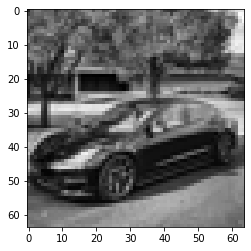

In [ ]:
plt.imshow(imgs[0,:,:,0], cmap='gray')
plt.show()

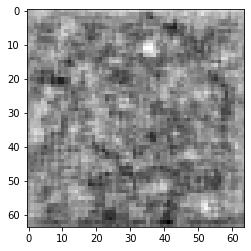

In [ ]:
import matplotlib.pyplot as plt

generator = make_generator(one_side_len = 64, depth=512)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
discriminator = make_discriminator(one_side_len=64,depth=512)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49998736]], shape=(1, 1), dtype=float32)


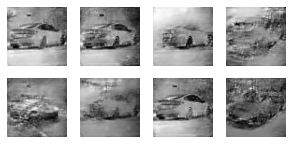

CPU times: user 2h 12min 26s, sys: 20.6 s, total: 2h 12min 47s
Wall time: 2h 12min 30s


In [ ]:
%%time
# tf.config.run_functions_eagerly(True)
train(customdata, 3000)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/Project_section4/checkpoints1024'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)